##Cheetahs_vs_Lions - Image Classification

##### the dataset used for this project is a combination of two dataset from kaggle, there are 300 images for training and 88 images for validation, each class have the same amount of samples.
 <https://www.kaggle.com/datasets/mikoajfish99/lions-or-cheetahs-image-classification/data>
and <https://www.kaggle.com/datasets/patriciabrezeanu/big-cats-image-classification-dataset>

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
from matplotlib import pyplot as plt
import numpy as np

# import dataset

In [13]:
import zipfile
# unzipfile
local_zip='/content/Cheetahs_vs_Lions.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall()
zip_ref.close()

In [10]:
import os

# set files' directory to variates

base_dir='/content/Cheetahs_vs_Lions'
train_dir=os.path.join(base_dir,'Train')
val_dir=os.path.join(base_dir,'Validation')

train_cheetahs_dir=os.path.join(train_dir,'cheetah')
train_lions_dir=os.path.join(train_dir,'lion')

val_cheetahs_dir=os.path.join(val_dir,'Cheetahs')
val_lions_dir=os.path.join(val_dir,'Lions')

# Explore dataset

In [15]:
# get filenames stored in a list
train_cheetahs_fnames=os.listdir(train_cheetahs_dir)
train_lions_fnames=os.listdir(train_lions_dir)

print(train_cheetahs_fnames[:3])
print(train_lions_fnames[:3])

['ed7855f9-cdc7-4bd8-8e92-2f2e2ac2830c.jpg', 'af4f43f0-6a78-45b8-a420-0e080c910de1.jpg', '0238989e-1c32-4529-b438-1bcf0d6419e5.jpg']
['13e2acb33f29b384.jpg', '2693c83a-0702-4c13-8a44-049c6da00d7f.jpg', '32d1472a-59a7-43d3-a894-1e50e6f35794.jpg']


In [16]:
print("total training cheetahs images:",len(os.listdir(train_cheetahs_dir)))
print("total training lions images:",len(os.listdir(train_lions_dir)))

print("total validaion cheetahs images:",len(os.listdir(val_cheetahs_dir)))
print("total validatin lions images:",len(os.listdir(val_lions_dir)))

total training cheetahs images: 150
total training lions images: 150
total validaion cheetahs images: 44
total validatin lions images: 44


## display some pictures in the dataset

In [17]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 2x4 configuration
nrows = 2
ncols = 4

pic_index = 0 # Index for iterating over images

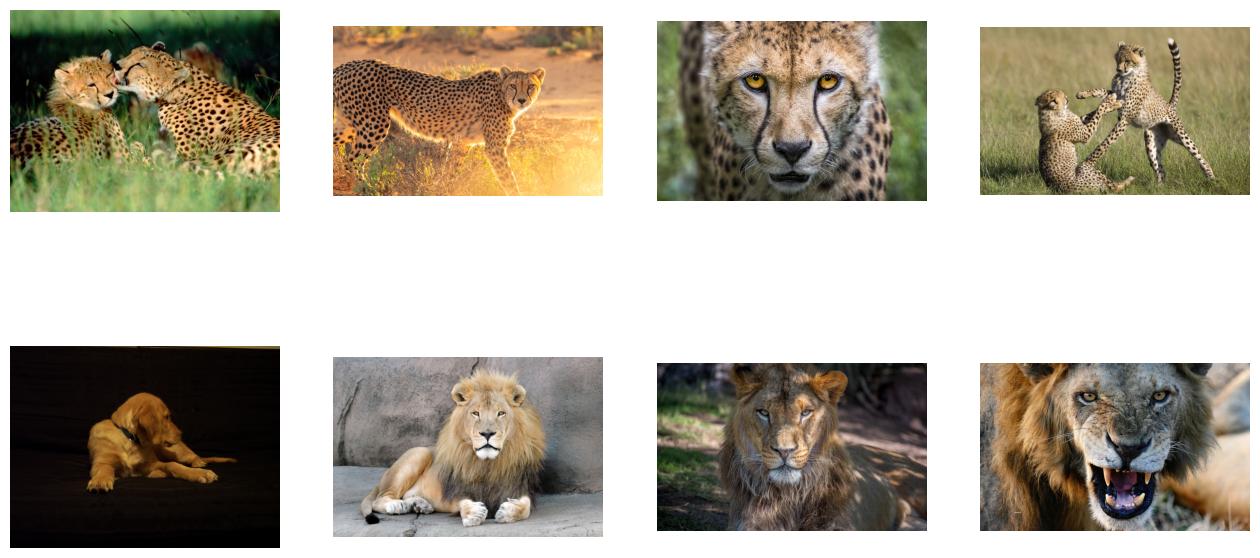

In [18]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=4

next_cheetahs_pix = [os.path.join(train_cheetahs_dir, fname)
                for fname in train_cheetahs_fnames[ pic_index-4:pic_index]
               ]

next_lions_pix = [os.path.join(train_lions_dir, fname)
                for fname in train_lions_fnames[ pic_index-4:pic_index]
               ]

for i, img_path in enumerate(next_cheetahs_pix+next_lions_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Data preprocess

### implement Data augmentation

In [11]:
train_datagen=ImageDataGenerator(rescale= 1./255.,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

val_datagen=ImageDataGenerator(rescale=1./255.)

In [31]:
train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=30,
    class_mode='binary'
)

val_generator=val_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=11,
    class_mode='binary'
)

Found 300 images belonging to 2 classes.
Found 88 images belonging to 2 classes.


# Bulid CNN

In [32]:
def create_model():
  model=Sequential()
  model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)))
  model.add(layers.MaxPooling2D(2,2))

  model.add(layers.Conv2D(64,(3,3),activation='relu'))
  model.add(layers.MaxPooling2D(2,2))

  model.add(layers.Conv2D(128,(3,3),activation='relu'))
  model.add(layers.MaxPooling2D(2,2))

  model.add(layers.Conv2D(128,(3,3),activation='relu'))
  model.add(layers.MaxPooling2D(2,2))

  model.add(layers.Flatten())
  model.add(layers.Dense(512,activation='relu'))
  model.add(layers.Dense(1,activation='sigmoid'))

  return model



In [25]:
model=create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)       0

## fine-tune the optimal learning_rate

In [43]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))

model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

history=model.fit(
    train_generator,
    steps_per_epoch=6,
    epochs=100,
    callbacks=[lr_schedule]

)

Epoch 1/100
6/6 [==============================] - 2s 83ms/step - loss: 0.7372 - accuracy: 0.3833 - lr: 1.0000e-05
Epoch 2/100
6/6 [==============================] - 1s 133ms/step - loss: 0.7415 - accuracy: 0.3500 - lr: 1.1220e-05
Epoch 3/100
6/6 [==============================] - 1s 131ms/step - loss: 0.7096 - accuracy: 0.5167 - lr: 1.2589e-05
Epoch 4/100
6/6 [==============================] - 1s 132ms/step - loss: 0.6945 - accuracy: 0.4667 - lr: 1.4125e-05
Epoch 5/100
6/6 [==============================] - 1s 134ms/step - loss: 0.7310 - accuracy: 0.3333 - lr: 1.5849e-05
Epoch 6/100
6/6 [==============================] - 1s 138ms/step - loss: 0.6889 - accuracy: 0.5167 - lr: 1.7783e-05
Epoch 7/100
6/6 [==============================] - 1s 138ms/step - loss: 0.6911 - accuracy: 0.5500 - lr: 1.9953e-05
Epoch 8/100
6/6 [==============================] - 1s 141ms/step - loss: 0.7152 - accuracy: 0.5000 - lr: 2.2387e-05
Epoch 9/100
6/6 [==============================] - 1s 132ms/step - loss: 

(1e-05, 0.1, 0.5, 1.0)

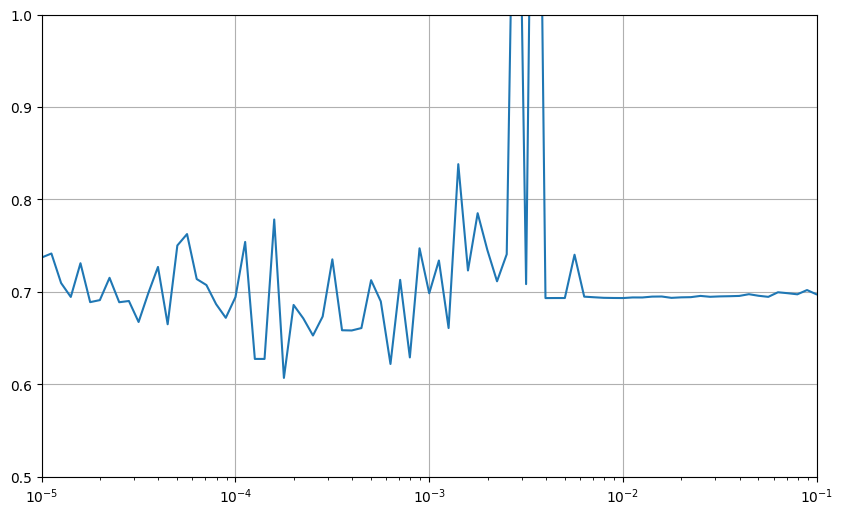

In [44]:
import numpy as np
import matplotlib.pyplot as plt

lr=1e-5 * 10**(np.arange(100) / 20)

plt.figure(figsize=(10,6))
plt.grid(True)

plt.semilogx(lr,history.history['loss'])
plt.axis([1e-5,1e-1,0.5,1])

## set the optimal learning_rate=1e-4

In [33]:
lr=1e-04

model=create_model()

model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=lr),metrics=['accuracy'])

history=model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=10,
    epochs=15,
    verbose=1,
    validation_steps=8
)

Epoch 1/15
10/10 [==============================] - 11s 991ms/step - loss: 0.6932 - accuracy: 0.5233 - val_loss: 0.6835 - val_accuracy: 0.5000
Epoch 2/15
10/10 [==============================] - 10s 1s/step - loss: 0.6917 - accuracy: 0.4900 - val_loss: 0.6787 - val_accuracy: 0.5568
Epoch 3/15
10/10 [==============================] - 10s 999ms/step - loss: 0.6810 - accuracy: 0.5533 - val_loss: 0.6660 - val_accuracy: 0.6818
Epoch 4/15
10/10 [==============================] - 10s 996ms/step - loss: 0.6668 - accuracy: 0.6267 - val_loss: 0.6594 - val_accuracy: 0.5227
Epoch 5/15
10/10 [==============================] - 10s 993ms/step - loss: 0.6534 - accuracy: 0.6267 - val_loss: 0.6421 - val_accuracy: 0.5795
Epoch 6/15
10/10 [==============================] - 10s 999ms/step - loss: 0.6333 - accuracy: 0.6700 - val_loss: 0.6378 - val_accuracy: 0.6023
Epoch 7/15
10/10 [==============================] - 10s 1s/step - loss: 0.6019 - accuracy: 0.6933 - val_loss: 0.6602 - val_accuracy: 0.5682
Epoch

# Evalute the results

In [34]:
def plot_loss_acc(x,y):
    for key, value in y.items():
      plt.plot(x,value,label=key)
    plt.grid(True)
    plt.legend()
    plt.show()

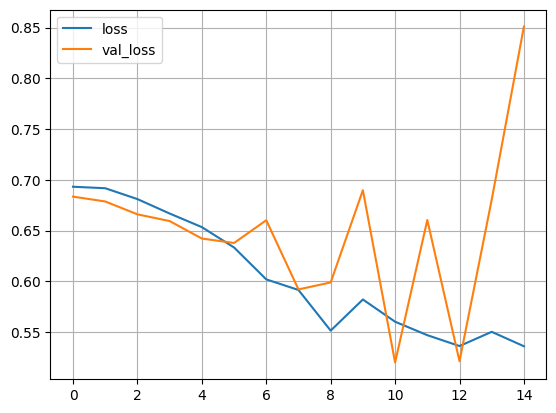

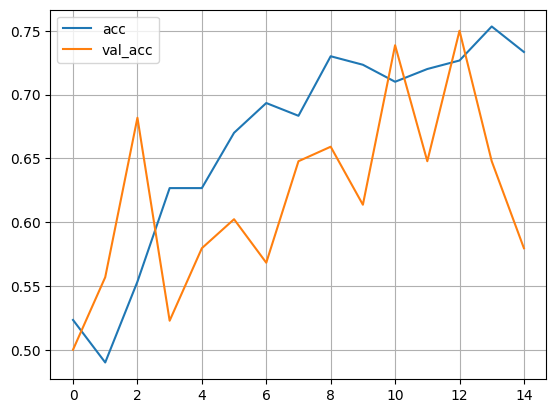

In [35]:
# plot the loss and accuracy curves
loss=history.history['loss']
acc=history.history['accuracy']

val_loss=history.history['val_loss']
val_acc=history.history['val_accuracy']

loss_set={
        "loss":loss,
        "val_loss":val_loss
        }
acc_set={
        "acc":acc,
        "val_acc":val_acc
        }

epochs=range(len(history.history['loss']))

plot_loss_acc(epochs,loss_set)
plot_loss_acc(epochs,acc_set)

In [36]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(150, 150))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a lion")
  else:
    print(fn + " is a cheetahs")

Saving 400401fd-6518-42fc-b7e1-ea996f2a7f97.jpg to 400401fd-6518-42fc-b7e1-ea996f2a7f97 (2).jpg
Saving a02e917d-0f07-4a22-823c-c787502ee295.jpg to a02e917d-0f07-4a22-823c-c787502ee295 (2).jpg
Saving adfdaaeb0e86ac94.jpg to adfdaaeb0e86ac94 (2).jpg
1/1 [==============================] - 0s 213ms/step
[0.513204]
400401fd-6518-42fc-b7e1-ea996f2a7f97 (2).jpg is a lion
1/1 [==============================] - 0s 20ms/step
[0.03998426]
a02e917d-0f07-4a22-823c-c787502ee295 (2).jpg is a cheetahs
1/1 [==============================] - 0s 19ms/step
[0.30517194]
adfdaaeb0e86ac94 (2).jpg is a cheetahs


# transfer learning

In [37]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-06-06 16:50:46--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  23.4MB/s    in 4.7s    

2024-06-06 16:50:51 (17.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [38]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,  # Set the input shape and remove the dense layers.
                                weights = None)


pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False # Freeze the weights of the layers.

In [39]:
last_layer = pre_trained_model.get_layer('mixed7') # Choose `mixed7` as the last layer of my base model
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [40]:

from tensorflow.keras import Model

x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])


In [41]:
class mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = mycallback()

history=model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=10,
    epochs=15,
    verbose=1,
    validation_steps=8,
    callbacks=[callbacks]
)

Epoch 1/15
10/10 [==============================] - 14s 1s/step - loss: 0.6034 - accuracy: 0.7633 - val_loss: 0.0935 - val_accuracy: 0.9773
Epoch 2/15
10/10 [==============================] - 10s 1s/step - loss: 0.1466 - accuracy: 0.9433 - val_loss: 0.1551 - val_accuracy: 0.9205
Epoch 3/15
10/10 [==============================] - 10s 997ms/step - loss: 0.1050 - accuracy: 0.9500 - val_loss: 0.0429 - val_accuracy: 0.9886
Epoch 4/15
10/10 [==============================] - 10s 984ms/step - loss: 0.0724 - accuracy: 0.9733 - val_loss: 0.0657 - val_accuracy: 0.9773
Epoch 5/15
10/10 [==============================] - 10s 964ms/step - loss: 0.1414 - accuracy: 0.9467 - val_loss: 0.0333 - val_accuracy: 0.9886
Epoch 6/15
10/10 [==============================] - 10s 1s/step - loss: 0.0470 - accuracy: 0.9800 - val_loss: 0.0677 - val_accuracy: 0.9659
Epoch 7/15
10/10 [==============================] - 10s 997ms/step - loss: 0.0483 - accuracy: 0.9833 - val_loss: 0.0247 - val_accuracy: 1.0000
Epoch 8/

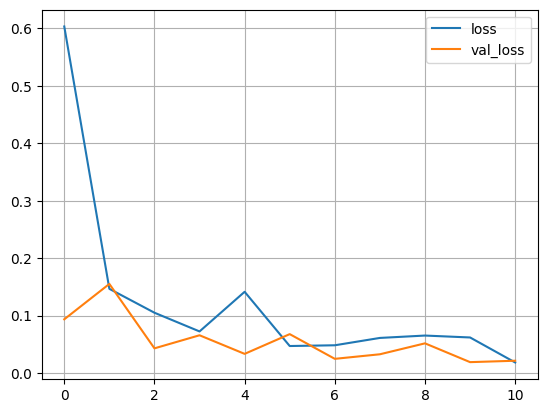

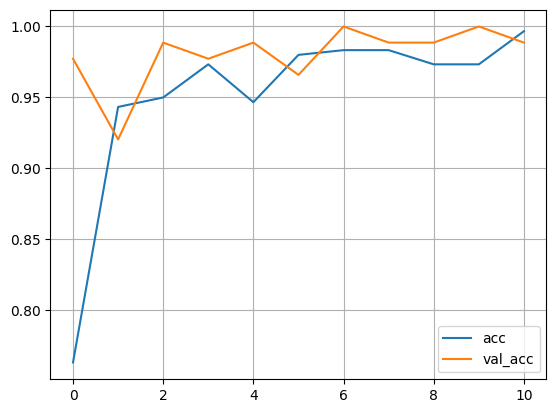

In [42]:
loss=history.history['loss']
acc=history.history['accuracy']

val_loss=history.history['val_loss']
val_acc=history.history['val_accuracy']

loss_set={
        "loss":loss,
        "val_loss":val_loss
        }
acc_set={
        "acc":acc,
        "val_acc":val_acc
        }

epochs=range(len(history.history['loss']))

plot_loss_acc(epochs,loss_set)
plot_loss_acc(epochs,acc_set)

# Model prediction

In [43]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(150, 150))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a lion")
  else:
    print(fn + " is a cheetahs")

Saving a02e917d-0f07-4a22-823c-c787502ee295.jpg to a02e917d-0f07-4a22-823c-c787502ee295 (3).jpg
Saving adfdaaeb0e86ac94.jpg to adfdaaeb0e86ac94 (3).jpg
1/1 [==============================] - 1s 951ms/step
[0.99994636]
a02e917d-0f07-4a22-823c-c787502ee295 (3).jpg is a lion
1/1 [==============================] - 0s 26ms/step
[0.999967]
adfdaaeb0e86ac94 (3).jpg is a lion


# Clean Up (terminate the kernel and free memory resources)

In [ ]:
import os, signal

os.kill(os.getpid(), signal.SIGKILL)